In [1]:
import pathlib
import os

import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compounds in each assay

In [2]:
run_dir = "/Users/sethhowes/Desktop/FS-Tox/multirun/2023-08-03/16-10-07"
dataset_dirs = [pathlib.Path(run_dir) / dataset_dir for dataset_dir in os.listdir(run_dir) if os.path.isdir(os.path.join(run_dir, dataset_dir))]
assay_dataset_dirs = [dataset_dir / 'data/processed/assay/*' for dataset_dir in dataset_dirs]

In [3]:
# Create a connection to DuckDB
con = duckdb.connect()

count_dfs = []

# For each parquet file, execute a SQL query to count the number of rows grouped by assay_id
for assay_dataset_dir in assay_dataset_dirs:
    query = f"""
    SELECT source_id AS dataset, COUNT(*) AS count
    FROM read_parquet('{assay_dataset_dir}')
    GROUP BY assay_id, source_id
    """
    df = con.execute(query).df()
    count_dfs.append(df)

assay_counts = pd.concat(count_dfs)
assay_counts = assay_counts[assay_counts["count"] <= 5000]

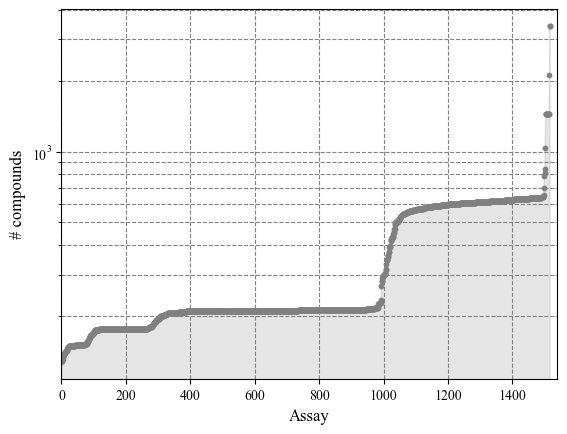

<Figure size 640x480 with 0 Axes>

In [11]:
assay_counts = assay_counts.sort_values('count')
assay_counts['assay_id'] = range(len(assay_counts))

plt.rcParams['font.family'] = 'Times New Roman'


# Create subplots
# fig, axes = plt.subplots(6, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [3] + [1] * 5})


# Plot the scatter plot and fill area under the points
x = np.arange(len(assay_counts['assay_id']))
y = assay_counts['count']

plt.scatter(x, y, color='gray', s=10)
plt.fill_between(x, y, color='gray', alpha=0.2) # Translucent fill
plt.yscale('log') # Logarithmic scale
plt.xlabel("Assay", fontsize=12)
plt.ylabel("# compounds", fontsize=12)
plt.xlim(0, 1540)
plt.grid(True,which="both",ls="--",c='gray')
plt.show()


# # Plot the smoothed distributions (KDE plots) for the distribution of assay sizes for each dataset
# unique_datasets = assay_counts['dataset'].unique()
# for i, dataset in enumerate(unique_datasets):
#     axes[i+1].set_title(dataset)
#     subset = assay_counts[assay_counts['dataset'] == dataset]
#     sns.kdeplot(x='count', data=subset, shade=True, ax=axes[i+1])
#     axes[i+1].set_xlabel('')  # Remove x-axis label

plt.tight_layout()
plt.show()

# Active compounds in each assay

In [5]:
active_dfs = []

# For each parquet file, execute a SQL query to count the number of rows grouped by assay_id
for assay_dataset_dir in assay_dataset_dirs:
    query = f"""
    SELECT source_id AS dataset, SUM(ground_truth) / COUNT(*) AS ratio
    FROM read_parquet('{assay_dataset_dir}')
    GROUP BY assay_id, source_id
    """
    df = con.execute(query).df()
    active_dfs.append(df)

assay_ratios = pd.concat(active_dfs)

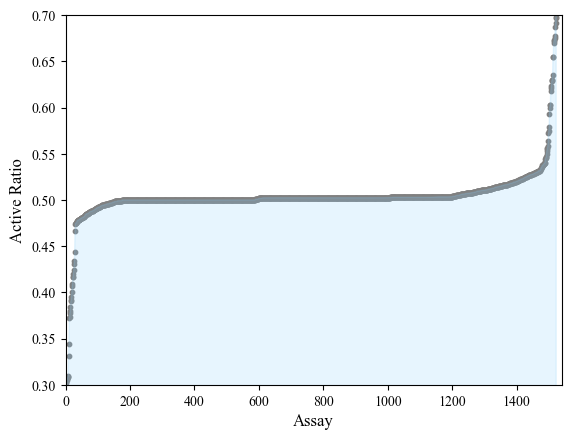

In [6]:
assay_ratios = assay_ratios.sort_values('ratio').reset_index(drop=True)
assay_ratios['assay_id'] = range(len(assay_ratios))

plt.rcParams['font.family'] = 'Times New Roman'

x = np.arange(len(assay_ratios['assay_id']))
y = assay_ratios['ratio']

plt.scatter(x, y, color='gray', s=10)
plt.fill_between(x, y, color='lightskyblue', alpha=0.2) # Translucent fill
plt.xlabel("Assay", fontsize=12)
plt.ylabel("Active Ratio", fontsize=12)
plt.xlim(0, 1540)
plt.ylim(0.3, 0.7)
plt.show()